In [1]:
import numpy as np
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix,isspmatrix,bmat
import scipy as sci
from qutip import qload
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def _exact_1_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=0).flat)
    else:
        return np.linalg.norm(A, 1)

def gamma_fa(n):
    u = 1.11e-16
    u=np.sqrt(2)*2*u/(1-2*u)
    return n*u/(1-n*u)
def beta(norm,m,n,tol):
    beta=gamma_fa(m+1)
    r = 1
    for i in range(1,m):
        r=r*norm/i
        g = gamma_fa(i*(n+2)+m+2)
        beta = beta+g*r
        if beta>tol:
            return 0,0
    return beta,r

def taylor_term(i,norm,term):
    return term*norm/i
def error(norm_B,m,s,n,R_m,tol):
    tr = R_m
    rd=beta(norm_B,m,n,tol)[0]
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd
def weaker_error(beta,R_m,s):
    tr = R_m
    rd=beta
    rd = np.power((1 + rd + tr), s) - np.power((1 + tr), s)
    tr = tr * s
    tr = tr * ((1 - np.power(tr, s)) / (1 - tr))
    return tr+rd
def residue_norm(m,norm_B,term):
    R_m=term
    for i in range(m+2,1000):
        term=term*norm_B/i
        R_m=R_m+term
        if term<1e-15:
            break
    return R_m

def choose_ms(norm_A,d,tol):
    no_solution=True
    for i in range(1,int(np.floor(norm_A))):
        if no_solution == False:
            break
        norm_B = norm_A / i
        l=int(np.floor(norm_B))
        beta_factor,last_term=beta(norm_B,l,d,tol)
        if beta_factor==0:
            continue
        lower_bound = i*(beta_factor)
        if lower_bound>tol:
            continue
        tr_first_term=norm_B
        m_pass_lowbound=False
        for j in range(1,100):
            if j>l:
                last_term=last_term*norm_B/j
                if last_term<1e-15:
                    break
                beta_factor=beta_factor+gamma_fa(j*(d+2)+2)*last_term
            if m_pass_lowbound == False:
                tr_first_term = tr_first_term * (norm_B / (j + 1))
                if i *tr_first_term + lower_bound > tol:
                    continue
                else:
                    R_m = residue_norm(j, norm_B, tr_first_term)
                    m_pass_lowbound = True
            if m_pass_lowbound == True:
                if weaker_error(beta_factor,R_m,i)>tol:
                    R_m = R_m - tr_first_term
                    tr_first_term = tr_first_term * norm_B / (j + 1)

                    continue
                else:
                    total_error=error(norm_B,j,i,d,R_m,tol)
                    R_m = R_m - tr_first_term
                    tr_first_term = tr_first_term * norm_B / (j + 1)
                    if total_error<tol:
                        no_solution = False
                        s=i
                        m=j
                        break

    if no_solution==False:
        return s,m
    if no_solution == True:
        raise ValueError("please lower the error tolerance ")
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def max_row_number(sparse_matrix):
    row_indice=sparse_matrix.nonzero()[0]
    indice_count=1
    max_count=1
    length=len(row_indice)
    indice = row_indice[0]
    for i in range(1,length):
        if indice==row_indice[i]:
            indice_count=indice_count+1
        else:
            if indice_count>max_count:
                max_count=indice_count
            indice=row_indice[i]
            indice_count=1
    return max_count
def expm_yunwei(A, B,d, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-5
    # if sci.sparse.isspmatrix(A):
    #     d=max_row_number(A)
    # else:
    #     d=len(A)
    norm_A = _exact_inf_norm(A)
    s,m=choose_ms(norm_A,d,tol)
    F=B
    for i in range(int(s)):
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        B = F
    return F,s*m

def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)

def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225*2*np.pi
    delta=3*2*np.pi
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    I_t = np.identity(Q_dim)
    I_c = np.identity(dim)
    H_trans = delta*np.dot(b_dag, b)+ 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b), np.dot(b_dag, b) - I_t)
    H_trans = np.kron(H_trans, I_c,)
    H_0 = (g * np.kron(b, a_dag, ) + g * np.kron(b_dag, a,) + H_trans)*1j*(-1j)
#     A=np.kron(a,np.identity(Q_dim))
#     A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
#     H_trans = delta*np.dot(b_dag, b)+1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
#     H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=0.25*csr_matrix(-1j*(H_0+0.1*2*np.pi*((np.dot(B_dag,B)+B+B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(HILBERT_SIZE*Q_dim)
    return H,vec

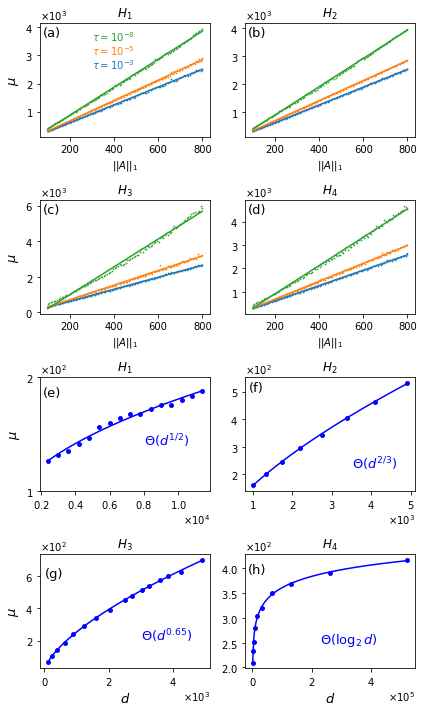

In [38]:
fig,(ax)=plt.subplots(4,2,figsize=(6,10))

norms=np.linspace(100,800,100)
tols=np.array([1e-3,1e-5,1e-8])
ms=np.zeros((len(norms),len(tols)))
aset=np.zeros(len(tols))
bset=np.zeros(len(tols))
for j in range(len(tols)):   
    for i in range(len(norms)):
        d=5
        s,m=choose_ms(norms[i],d,tol=tols[j])
        ms[i][j]=m*s
for j in range(len(tols)):
    power=1
    dim=norms
    x = (np.array(dim))**1
    fit = np.polyfit(dim**power, ms[:,j], 1)
    a=fit[0]
    b=fit[1]
    aset[j]=a
    bset[j]=b
#     ms[:,j]=(ms[:,j]-b)/x
    xx=np.linspace(dim[0],dim[-1],200)
    y=(a*np.power(xx,power)+b)
    ax[0][0].plot(xx ,y)
for j in range(len(tols)):
    ax[0][0].scatter(x, ms[:,j],s=0.5,label=None)
ax[0][0].set_title("$H_1 $")
    
norms=np.linspace(100,800,100)
tols=np.array([1e-3,1e-5,1e-8])
ms=np.zeros((len(norms),len(tols)))
aset=np.zeros(len(tols))
bset=np.zeros(len(tols))
for j in range(len(tols)):   
    for i in range(len(norms)):
        d=8
        s,m=choose_ms(norms[i],d,tol=tols[j])
        ms[i][j]=m*s
for j in range(len(tols)):
    power=1
    dim=norms
    x = (np.array(dim))**1
    fit = np.polyfit(dim**power, ms[:,j], 1)
    a=fit[0]
    b=fit[1]
    aset[j]=a
    bset[j]=b
#     ms[:,j]=(ms[:,j]-b)/x
    xx=np.linspace(dim[0],dim[-1],200)
    y=(a*np.power(xx,power)+b)
    ax[0][1].plot(xx ,y, label="$\tau$="+str(tols[j]))
    ax[0][1].scatter(x, ms[:,j],s=0.5)  
ax[0][1].set_title("$H_2$")   

norms=np.linspace(100,800,100)
tols=np.array([1e-3,1e-5,1e-8])
ms=np.zeros((len(norms),len(tols)))
aset=np.zeros(len(tols))
bset=np.zeros(len(tols))
for j in range(len(tols)):   
    for i in range(len(norms)):
        d=1.6229404069641764*norms[i] -1.1776743571230195
        s,m=choose_ms(norms[i],d,tol=tols[j])
        ms[i][j]=m*s
for j in range(len(tols)):
    power=1
    dim=norms
    x = (np.array(dim))**1
    fit = np.polyfit(dim**power, ms[:,j], 1)
    a=fit[0]
    b=fit[1]
    aset[j]=a
    bset[j]=b
#     ms[:,j]=(ms[:,j]-b)/x
    xx=np.linspace(dim[0],dim[-1],200)
    y=(a*np.power(xx,power)+b)
    ax[1][0].plot(xx ,y, label="$\tau$="+str(tols[j]))
    ax[1][0].scatter(x, ms[:,j],s=0.5)  
ax[1][0].set_ylabel('$\mu$',fontsize = 13)

norms=np.linspace(100,800,100)
tols=np.array([1e-3,1e-5,1e-8])
ms=np.zeros((len(norms),len(tols)))
aset=np.zeros(len(tols))
bset=np.zeros(len(tols))
for j in range(len(tols)):   
    for i in range(len(norms)):
        d=0.19*norms[i]+1.8
        s,m=choose_ms(norms[i],d,tol=tols[j])
        ms[i][j]=m*s
for j in range(len(tols)):
    power=1
    dim=norms
    x = (np.array(dim))**1
    fit = np.polyfit(dim**power, ms[:,j], 1)
    a=fit[0]
    b=fit[1]
    aset[j]=a
    bset[j]=b
#     ms[:,j]=(ms[:,j]-b)/x
    xx=np.linspace(dim[0],dim[-1],200)
    y=(a*np.power(xx,power)+b)
    ax[1][1].plot(xx ,y, label="$\tau$="+str(tols[j]))
    ax[1][1].scatter(x, ms[:,j],s=0.5)  

ax[0][0].set_ylabel('$\mu$',fontsize = 13)
# ax[0][0].legend(("$τ=10^{-3}$","$τ=10^{-5}$","$τ=10^{-8}$"),loc='upper center',ncol=2)
ax[0][0].text(80,3700, '(a)',fontsize = 13)
ax[0][1].text(80,3700, '(b)',fontsize = 13)
ax[1][0].text(80,5600, '(c)',fontsize = 13)
ax[1][1].text(80,4350, '(d)',fontsize = 13)
ax[0][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[0][1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[1][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[1][1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[1, 0].set_title("$H_3$")
ax[1][1].set_title("$H_4$") 
ax[0][0].text(300,2500, '$τ=10^{-3}$',color='#1f77b4')
ax[0][0].text(300,3000, '$τ=10^{-5}$',color='#ff7f0e')
ax[0][0].text(300,3500, '$τ=10^{-8}$',color='#2ca02c')

ax[0][0].set_xlabel("$||A||_1$")
ax[0][1].set_xlabel("$||A||_1$") 
ax[1][0].set_xlabel("$||A||_1$")
ax[1][1].set_xlabel("$||A||_1$") 





dims,norms,ms=np.load("./H1.npy")
power=0.5
dim=6*dims
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax[2,0].plot(xx, y,color='blue')
ax[2,0].scatter(x, ms, color='blue',s=15)
ax[2,0].title.set_text("$H_1$")

dims,norms,ms=np.load("./H4.npy")
power=2/3
dim=dims**3
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax[2,1].plot(xx, y,color='blue')
ax[2,1].scatter(x, ms, color='blue',s=15)
ax[2,1].title.set_text("$H_2$")

dims,norms,ms=np.load("./H3.npy")
power=0.65
dim=dims**2
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax[3,0].plot(xx, y,color='blue')
ax[3,0].scatter(x, ms, color='blue',s=15)

ax[3,0].title.set_text("$H_3$")

dims,norms,ms=np.load("./H5.npy")
power=1
dim=2**dims
x = (np.array(dim))**1
fit = np.polyfit(dims, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.log2(xx)+b)
ax[3,1].plot(xx, y,color='blue')
ax[3,1].scatter(x, ms, color='blue',s=15)

ax[3,0].set_xlabel('$d$',fontsize = 13)
ax[3,1].set_xlabel('$d$',fontsize = 13)
ax[2,0].set_ylabel('$\mu$',fontsize = 13)
ax[2,0].text(2100,183, '(e)', fontsize = 13)
ax[3,0].set_ylabel('$\mu$',fontsize = 13)
ax[2,1].text(900,502, '(f)', fontsize = 13)
ax[3,0].text(0,590, '(g)', fontsize = 13)
ax[3,1].text(-15000,390, '(h)', fontsize = 13)
ax[2,0].text(8000,140, '$\Theta(d^{1/2})$',fontsize = 13,color='blue')
ax[2,1].text(3500,220, '$\Theta(d^{2/3})$',fontsize = 13,color='blue')
ax[3,0].text(3000,200, '$\Theta(d^{0.65})$',fontsize = 13,color='blue')
ax[3,1].text(230000,250, '$\Theta(\log_2d)$',fontsize = 13,color='blue')
ax[2][0].set_ylim(1e2,2e2)
ax[2][0].set_ylim(1e2,2e2)
ax[2][0].set_yticks([100,200])
ax[2][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[2][1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[3][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[3][1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[2][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[2][1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[3][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[3][1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[3,1].set_title("$H_4$")

fig.tight_layout()
plt.savefig("uscaling.pdf", bbox_inches="tight")

transmon+resonator in rf, increase dimension of resonator

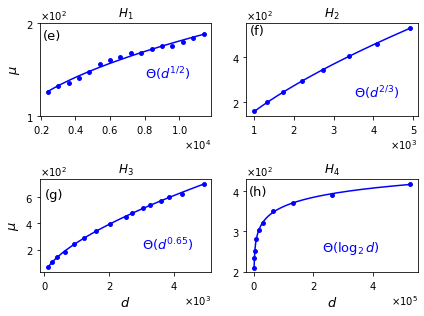

In [26]:
fig, ax = plt.subplots(2, 2,figsize=(6,4.5))
dims,norms,ms=np.load("./H1.npy")
power=0.5
dim=6*dims
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax[0,0].plot(xx, y,color='blue')
ax[0,0].scatter(x, ms, color='blue',s=15)
ax[0,0].title.set_text("$H_1$")

dims,norms,ms=np.load("./H4.npy")
power=2/3
dim=dims**3
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax[0,1].plot(xx, y,color='blue')
ax[0,1].scatter(x, ms, color='blue',s=15)
ax[0,1].title.set_text("$H_2$")

dims,norms,ms=np.load("./H3.npy")
power=0.65
dim=dims**2
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax[1,0].plot(xx, y,color='blue')
ax[1,0].scatter(x, ms, color='blue',s=15)

ax[1,0].title.set_text("$H_3$")

dims,norms,ms=np.load("./H5.npy")
power=1
dim=2**dims
x = (np.array(dim))**1
fit = np.polyfit(dims, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.log2(xx)+b)
ax[1,1].plot(xx, y,color='blue')
ax[1,1].scatter(x, ms, color='blue',s=15)

ax[1,0].set_xlabel('$d$',fontsize = 13)
ax[1,1].set_xlabel('$d$',fontsize = 13)
ax[0,0].set_ylabel('$\mu$',fontsize = 13)
ax[0,0].text(2100,183, '(e)', fontsize = 13)
ax[1,0].set_ylabel('$\mu$',fontsize = 13)
ax[0,1].text(900,502, '(f)', fontsize = 13)
ax[1,0].text(0,590, '(g)', fontsize = 13)
ax[1,1].text(-15000,390, '(h)', fontsize = 13)
ax[0,0].text(8000,140, '$\Theta(d^{1/2})$',fontsize = 13,color='blue')
ax[0,1].text(3500,220, '$\Theta(d^{2/3})$',fontsize = 13,color='blue')
ax[1,0].text(3000,200, '$\Theta(d^{0.65})$',fontsize = 13,color='blue')
ax[1,1].text(230000,250, '$\Theta(\log_2d)$',fontsize = 13,color='blue')
ax[0][0].set_ylim(1e2,2e2)
ax[0][0].set_ylim(1e2,2e2)
ax[0][0].set_yticks([100,200])
ax[0][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[0][1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[1][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[1][1].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
ax[0][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[0][1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[1][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[1][1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax[1,1].set_title("$H_4$")
fig.tight_layout()
plt.savefig("uvsd.pdf", bbox_inches="tight")

In [82]:
def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225*2*np.pi
    omega_c=3*2*np.pi
    omega_t=6*2*np.pi
    delta=3*2*np.pi
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    I_t = np.identity(Q_dim)
    I_c = np.identity(dim)
    H_trans = omega_t*np.dot(b_dag, b)+ 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b), np.dot(b_dag, b) - I_t)
    H_cav=np.kron(I_t,omega_c*np.dot(a_dag,a))
    H_trans = np.kron(H_trans, I_c,)
    H_0 = (g * np.kron(b, a_dag, ) + g * np.kron(b_dag, a,) + H_trans)*1j*(-1j)
#     A=np.kron(a,np.identity(Q_dim))
#     A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
#     H_trans = delta*np.dot(b_dag, b)+1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
#     H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=0.25*csr_matrix(-1j*(H_cav+H_0+0.1*2*np.pi*((np.dot(B_dag,B)+B+B_dag))))
    return H

transmon+resonator in lab frame, increase resonator dimension

In [29]:
dims=np.array([100,150,200,250,300,350,400])
ms=np.zeros(len(dims))
norms=np.zeros(len(dims))
for i in range(len(dims)):
    H=get_H(dims[i],np.float64)
    norm_A=_exact_inf_norm(H)
    d=max_row_number(H)
    s,m=choose_ms(norm_A,d,tol=1e-8)
    norms[i]=norm_A
    ms[i]=m*s
np.save("./H2",[dims,norms,ms])

4.039880952380952 -172.82142857142676


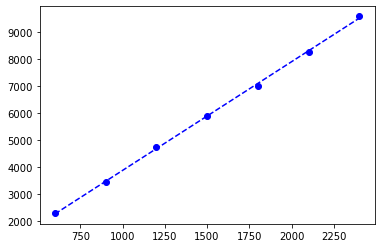

In [30]:
dims,norms,ms=np.load("./H2.npy")
power=1
fig, ax1 = plt.subplots()
dim=6*dims
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax1.plot(xx, y, '--',color='blue', label = 'Manual')
ax1.scatter(x, ms, color='blue')
print(a,b)

In [188]:
scq.GUI()

Output(layout=Layout(width='975px'))

transmon+harminoc oscllator, lab frame, increase dimension of transmon

In [35]:
import scqubits as scq
def get_H(dim):
    fluxonium1 = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 100,
                           truncated_dim=dim
                          )
    fluxonium2 = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 100,
                          truncated_dim=dim)
    hilbertspace=scq.HilbertSpace([fluxonium1,fluxonium2])
    hilbertspace.add_interaction(
        g_strength=0.1*2*np.pi,
        op1=fluxonium1.n_operator,
        op2=fluxonium2.n_operator,
        add_hc=False
    )
    EL = 0.5
    phi_t=0.1*2*np.pi
    H=hilbertspace.hamiltonian().data
    -EL*phi_t*scq.identity_wrap(fluxonium1.phi_operator(), fluxonium1, hilbertspace.subsys_list).data
    -EL*phi_t*np.pi*scq.identity_wrap(fluxonium2.phi_operator(), fluxonium2, hilbertspace.subsys_list).data
    +EL*phi_t**2
    return -1j*H*0.25

dims=np.array([10,15,20,25,30,35,40,45,50,52,55,57,60,62,65,70])

ms=np.zeros(len(dims))
norms=np.zeros(len(dims))
for i in range(len(dims)):
    H=get_H(int(dims[i]))
    norm_A=np.real(_exact_inf_norm(H))
    d=max_row_number(H)
    print(norm_A,d)
    s,m=choose_ms(norm_A,d,tol=1e-8) 
    norms[i]=norm_A
    ms[i]=m*s
np.save("./H3",[dims,norms,ms])


15.024668620372772 82
23.478367776246188 197
31.178277231634862 362
39.17804386525757 577
47.78232538682046 842
55.513239445509655 1157
63.31666531566729 1522
71.46538700564784 1937
80.0917592851044 2402
83.4838412874971 2602
88.39518407936785 2917
91.7263081819156 3137
96.22398592492367 3482
99.11886422172778 3722
104.34132430297824 4097
112.29078956760603 4762


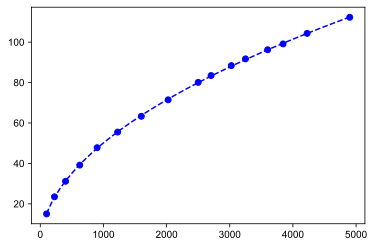

In [40]:
power=0.5
fig, ax1 = plt.subplots()
dim=dims**2
x = (np.array(dim))**1
fit = np.polyfit(dim**power, norms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax1.plot(xx, y, '--',color='blue', label = 'Manual')
ax1.scatter(x, norms, color='blue')

In [43]:
a,b

(1.6229404069641764, -1.1776743571230195)

In [73]:
norms

array([ 373.49684025,  800.50205364, 1504.66784201, 2490.7013807 ,
       3767.8340387 ])

3 coupled trasmon in rf

In [21]:
import numpy as np
from numpy import identity, kron
def get_control(N):
    sigmap=get_creation_operator(N,np.float64)
    sigmam = get_annihilation_operator(N,np.float64)
    sigmax=sigmap+sigmam
    control=[]
    if N==1:
        control.append(kron(sigmax, identity(N ** (3))))
        return control
    else:
        a=identity(N**(2))
        control.append(kron(sigmax,a))
        for i in range(1,2):
            control.append(kron(kron(identity(N**i),sigmax), identity(N ** (2-i))))
        control.append(kron(identity(N**(2)),sigmax))
    return control
def get_int(N):
    alpha=-0.225*2*np.pi
    g=0.1*2*np.pi
    sigmap=get_creation_operator(N,np.float64)
    sigmam = get_annihilation_operator(N,np.float64)
    sigmaz=sigmap.dot(sigmam)
    H_int=g*(kron(sigmam,sigmap)+kron(sigmap,sigmam))
    H0=0
    H_anh=1/2*alpha*(sigmaz*(sigmaz-identity(N)))
    H0=kron(H_anh,identity(N**2))
    H0=H0+kron(identity(N),kron(H_anh,identity(N)))
    H0 = H0 + kron(identity(N**2), H_anh)
    H0 = H0 + kron(H_int,identity(N))
    H0 = H0 + kron(identity(N ),H_int)
    return H0
def control_H(control,H_control):
    H=0
    for i in range(len(control)):
        H=H+control[i]*H_control[i]
    return H
def get_H(N):
    control=get_control(N)
    control_pra=0.5*np.ones(np.array(control).shape[0])
    H_control=control_H(control_pra,control)
    H=-1j*(H_control+get_int(N))
    vec=1/np.sqrt(N**3)*np.ones(N**3)
    return H

dims=np.array([5])

ms=np.zeros(len(dims))
norms=np.zeros(len(dims))
for i in range(len(dims)):
    H=get_H(dims[i])
    norm_A=_exact_inf_norm(H)
    d=max_row_number(H)
    s,m=choose_ms(norm_A,d,tol=1e-8)
    norms[i]=norm_A
    ms[i]=m*s
# np.save("./H4",[dims,norms,ms])


In [22]:
norm_A*1

30.09832406125921

In [10]:
temci short exec  "python yunwei_2_t1.py" "python yunwei_2_t2.py" "python yunwei_2_t3.py" "python yunwei_2_t4.py" "python yunwei_2_t5.py" "python yunwei_2_t6.py" "python yunwei_2_t7.py" "python yunwei_2_t8.py" "python yunwei_2_t9.py" "python yunwei_2_t10.py" "python yunwei_2_t11.py" "python yunwei_2_t12.py" "python yunwei_2_t13.py" "python yunwei_2_t14.py" "python yunwei_5_t1.py" "python yunwei_5_t2.py" "python yunwei_5_t3.py" "python yunwei_5_t4.py" "python yunwei_5_t5.py" "python yunwei_5_t6.py" "python yunwei_5_t7.py" "python yunwei_5_t8.py" "python yunwei_5_t9.py" "python yunwei_5_t10.py" "python yunwei_5_t11.py" "python yunwei_5_t12.py" "python yunwei_5_t13.py" "python yunwei_5_t14.py" "python yunwei_8_t1.py" "python yunwei_8_t2.py" "python yunwei_8_t3.py" "python yunwei_8_t4.py" "python yunwei_8_t5.py" "python yunwei_8_t6.py" "python yunwei_8_t7.py" "python yunwei_8_t8.py" "python yunwei_8_t9.py" "python yunwei_8_t10.py" "python yunwei_8_t11.py" "python yunwei_8_t12.py" "python yunwei_8_t13.py" "python yunwei_8_t14.py" "python yunwei_12_t1.py" "python yunwei_12_t2.py" "python yunwei_12_t3.py" "python yunwei_12_t4.py" "python yunwei_12_t5.py" "python yunwei_12_t6.py" "python yunwei_12_t7.py" "python yunwei_12_t8.py" "python yunwei_12_t9.py" "python yunwei_12_t10.py" "python yunwei_12_t11.py" "python yunwei_12_t12.py" "python yunwei_12_t13.py" "python yunwei_12_t14.py" --runs 20 --sudo --preset usable


11

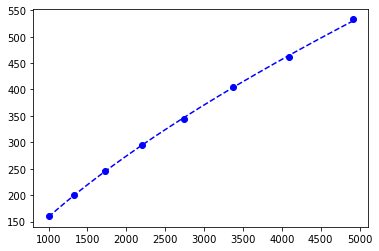

In [4]:
dims,norms,ms=np.load("./H4.npy")
power=2/3
fig, ax1 = plt.subplots()
dim=dims**3
x = (np.array(dim))**1
fit = np.polyfit(dim**power, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.power(xx,power)+b)
ax1.plot(xx, y, '--',color='blue', label = 'Manual')
ax1.scatter(x, ms, color='blue')

In [11]:
from scipy.sparse import identity, kron
def get_int(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmaz=sigmap.dot(sigmam)
    H0=0
    SIGMAZ=kron(sigmaz,sigmaz)
    H0=H0+kron(SIGMAZ,identity(2**(N-2)))+kron(identity(2**(N-2)),SIGMAZ)
    for i in range(1,N-2):
        H0=H0+kron(kron(identity(2**i),SIGMAZ),identity(2 ** (N - 2 - i)))
    return H0
def get_control(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmap=sigmap
    sigmam=sigmam
    sigmax=sigmap+sigmam
    sigmay=-1j*sigmap+1j*sigmam
    control=[]
    if N==1:
        control.append(kron(sigmax, identity(2 ** (N - 1))))
        control.append(kron(sigmay, identity(2 ** (N - 1))))
        return control
    else:
        a=identity(2**(N-1))
        control.append(kron(sigmax,a,format="csc"))
        control.append(kron(sigmay, identity(2 ** (N - 1)),format="csc"))
        for i in range(1,N-1):
            control.append(kron(kron(identity(2**i),sigmax), identity(2 ** (N - 1-i)),format="csc"))
            control.append(kron(kron(identity(2 ** i), sigmay), identity(2 ** (N - 1 - i)),format="csc"))
        control.append(kron(identity(2**(N-1)),sigmax,format="csc"))
        control.append(kron(identity(2**(N-1)),sigmay,format="csc"))
    return control
def control_H(control,H_control):
    H=0
    for i in range(len(control)):
        H=H+control[i]*H_control[i]
    return H
def get_H(N):
    tp=np.float64
    control=get_control(N,tp)
    control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
    H_control=control_H(control_pra,control)
    H=-1j*(H_control+get_int(N,tp)*0.1*2*np.pi)
    return H
dims=np.array([10,11,12,13,14,15,16,17,18,19])

ms=np.zeros(len(dims))
norms=np.zeros(len(dims))
for i in range(len(dims)):
    H=get_H(dims[i])
    norm_A=_exact_inf_norm(H)
    d=max_row_number(H)
    print(d,norm_A)
    s,m=choose_ms(norm_A,d,tol=1e-8)
    norms[i]=norm_A
    ms[i]=m*s
np.save("./H5",[dims,norms,ms])

11 50.083696158045285
12 55.1548976269216
13 60.22609909579793
14 65.29730056467425
15 70.36850203355057
16 75.43970350242688
17 80.5109049713032
18 85.58210644017953
19 90.65330790905585
20 95.72450937793218


In [22]:
0.19*95+1.8

19.85

qubits chain in the rotating frame

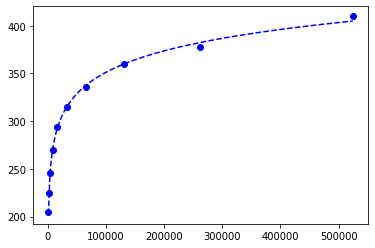

In [16]:
dims,norms,ms=np.load("./H5.npy")
power=1
fig, ax1 = plt.subplots()
dim=2**dims
x = (np.array(dim))**1
fit = np.polyfit(dims, ms, 1)
a=fit[0]
b=fit[1]
xx=np.linspace(dim[0],dim[-1],200)
y=(a*np.log2(xx)+b)
ax1.plot(xx, y, '--',color='blue')
ax1.scatter(x, ms, color='blue')

In [1]:
def func2():
    return np.array([1,2,3])
def func(a):
    if a==1:
        import numpy as np
    else:
        import autograd.numpy as np
    return func2()

In [2]:
func(2)

NameError: name 'np' is not defined